# Building an Image Recognition System Using CNN's

Versions used in this notebook.

In [0]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
import keras.backend as K

Using TensorFlow backend.


In [0]:
import keras
print("Using Keras version: {}".format(keras.__version__))
import tensorflow
print("Using Tensorflow version: {}".format(tensorflow.__version__))

Using Keras version: 2.2.4
Using Tensorflow version: 1.12.0


In [0]:
!python -V

Python 3.6.7


In [0]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17596082907015155366, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 2348671273572910438
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 11841475214716962622
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11281553818
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13769721518229418656
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

This notebook is using Keras version 2.2.4, Tensorflow 1.12.0 using a Google Colab GPU (Tesla K80).

# Introduction:

Greetings! In this notebook I will walk through the process of creating an image recognition system capable of classifying hand written digits and recognizing various random objects such as airplanes, dogs, cats, and frogs! 

# Data
We will be using the classic MNIST dataset and the CIFAR10 dataset. The MNIST dataset consists of of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images. CIFAR consists of 50,000 32x32 color training images, labeled over 10 categories, and 10,000 test images.

# Analytic plan

The process will be as follows for both part 1 (MNIST) and part 2 (CIFAR10):

1. Define the problem, both as a data science task and as a business objective.
2. Choose a measure of sucess to evaluate the performance of the image recognizer (model).
3. Decide evaluation protocol.
4. Prepare data.
5. Build model and evaluate on unseen images (test data).
6. Summarize

To help give this project a real world context I'll use a hypothetical business scenario with a couple of objectives (inspired by Dataweekends, link below).

https://github.com/Dataweekends/zero_to_deep_learning_video

# Business scenario:

I have recently been hired by a shipping company to overhaul the way they route mail, parcels and packages. The first business objective is to build an image recognition system capable of recognizing the digits in the zipcode of a package, so that it can be automatically routed to the correct location. The business stakeholders would like to automate this process using a digit recognition system. 

The second business objective involves the shipping companies online branch. Their online branch allows people to upload images to a website that generates and prints postcards that are later shipped to their destination. The business stakeholders would like to know what images people are loading on the site in order to provide targeted advertising on the same page. The objective is to build an image recognition system capable of recognizing a few objects that are common to postcards. 

### Part 1, MNIST:

# 1. Defining the problem

Recognizing 10 digits, and 10 objects, is primarily a multiclass classification problem. Deep learning algorithms tend to shine on image classification problems, so were going to use them for our image recognizer. They work by transforming the data into a useful representation - essentially filtering and distilling the data into some desired output (in our case a probability). And while there are a variety of neural network architectures that we could choose from, for this project we will use a convolutional neural network (CNN),  since it is known to have great sucess in the field of computer vision. 

CNN contain convolution layers that differ from densely connected layers (Dense). While densely connect layers learn global patterns, convolution layers learn *local patterns* using small 2D windows of the features. They tend to work well because those local patterns can then be found anywhere - allowing them better recognize images that the model wasn't trained on. They also learn what is known as *hierarchies of patterns* -  which basically means they create layers of abstractions. Combining these convolution layers with pooling and dense layers, we can distill the images down to smaller representations that are useful l for making predictions.

Since CNN's take as input tensors of shape (image_height, image_width, image_channels), well have to prepare the data before we input it into the model.

# 2. Choosing a measure of sucess

- loss: categorical cross entropy
- optimizer: rmsprop or adam
- evaluation metric: accuracy

# 3. Decide evaluation protocal

We will divide our data into training and testing datasets. During training we set aside 10% of the data for validation. The split is 40% training, 10% validation, 50% testing.

# 4. Prepare the data

First well load in the data and prepare the features for the model.

In [0]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(60000, 28, 28) (10000, 28, 28)
(60000,) (10000,)


Heres what the images look like in this dataset. Each picture has 28x28 pixel dimensions.

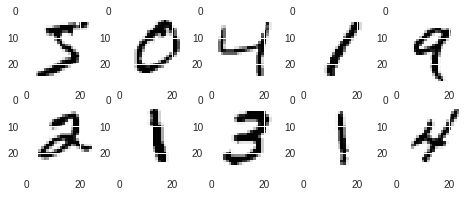

In [0]:
# plt.imshow(X_train[0], cmap='gray')
plt.figure(figsize=(8,3))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(X_train[i])

With a shape of (60000, 28, 28) and (10000, 28, 28) we'll need to first reshape the features into a 4D tensor of *Batch Dimension Nonex Height 28x Width 28x Channel 1* - not including the batch dimension since well get to that later. 

After reshaping, we need to convert it to a float32 and divide it by 255, making all of the values between 0-1.

In [0]:
X_train = X_train.reshape((60000,28,28,1))
X_test = X_test.reshape((10000,28,28,1))

X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

print(X_train.shape, X_test.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


Now, we need to transform the target data by one-hot-encoding it using the Keras to_categorical() function. This will create a tensor of (batch dimension, 10), giving each digit class its own column.

In [0]:
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

print(y_train.shape, y_test.shape)

(60000, 10) (10000, 10)


# 5. Model the data

For the first business task - creating an image recognition system - we will create a layered CNN. The process is as follows:

- Build model
- Compile and train the model
- Evaluate model


### Building the Model

In [0]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


The architecture is as follows:

- The first Conv2D layer will take in the input tensor of shape (28, 28, 1) and then produce an output of 32 neurons with a (3, 3) kernel size. The activation function is 'relu'.
- We then add a MaxPool2D layer with a pool size of (2,2).
- Another Conv2D layer that takes in the 32 inputs and produces 64 outputs of shape (11, 11, 64). The activation function is 'relu'.
- We then add another MaxPool2D layer with a (2, 2) pool size. The output is now (5, 5, 64) - the height and width dimensions are shrinking.
- Finally, another Conv2D layer with 64 neurons that outputs a tensor of (3, 3, 64). 
- The model has 55,744 parameters.

We will now feed out output tensor into a densely connected classifying network. This last part will do the actual classifying.

In [0]:
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                36928     
__________

After the model distilled the images down to a smaller representation (a 3D tensor), it was then proccessed into a densely connected classifying network.

Notice that the output tensor is of shape (3, 3, 64). Classifiers process 1D vectors, so before we use it as input, we need to flatten it out using the Keras Flatten layer. Looking above you can see that the 3D tensor was flattened to a vector of (576,), which resulted by multiplying 3*3*64=576. This transforms the 3D tensor into a 1D vector. I decided to add a few dense layers on top to increase the complexity of the model. 

Since we are doing a 10-class classification, the final output layer has 10 neurons with the 'softmax' activation function. 

The model now has 93,322 parameters.

### Compiling and Training the Model

For the digit recognition task we will use the 'rmsprop' optimizer. Since we are doing a classification task we will use categorical_crossentropy as our loss function that we are trying to minimize. Our evaluation metric will be accuracy.

We will train the model for 5 epochs using a batch_size of 64.

In [0]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/5
54000/54000 [==============================] - 10s 190us/step - loss: 0.1856 - acc: 0.9424 - val_loss: 0.0604 - val_acc: 0.9837
Epoch 2/5
54000/54000 [==============================] - 9s 167us/step - loss: 0.0496 - acc: 0.9845 - val_loss: 0.0466 - val_acc: 0.9860
Epoch 3/5
54000/54000 [==============================] - 9s 168us/step - loss: 0.0336 - acc: 0.9898 - val_loss: 0.0370 - val_acc: 0.9902
Epoch 4/5
54000/54000 [==============================] - 9s 168us/step - loss: 0.0256 - acc: 0.9919 - val_loss: 0.0404 - val_acc: 0.9887
Epoch 5/5
54000/54000 [==============================] - 9s 168us/step - loss: 0.0201 - acc: 0.9937 - val_loss: 0.0444 - val_acc: 0.9880


Lets now visualize the results of the training. We'll create a history dictionary and store the training loss and accuracy in variables so we can plot them.

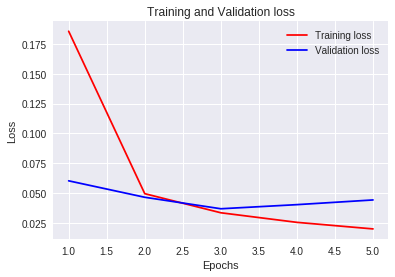

In [0]:
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
acc = history_dict['acc']
val_acc = history_dict['val_acc']

epochs = range(1,6)
plt.plot(epochs, loss, c='r', label='Training loss')
plt.plot(epochs, val_loss, c='b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Looking at the plot above we can see that the training loss decreases rapidly over 2 epochs and then begins slow down.  This is expected since our algorithm has learned the best parameters (or best representation) to minimize error. The validation set started, and ended, with a low loss. Lets now take a look at the accuracy.

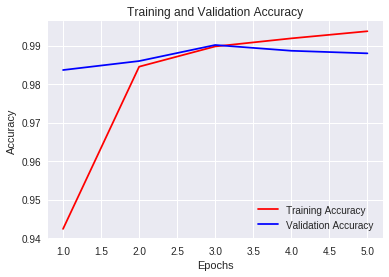

In [0]:
plt.plot(epochs, acc, c='r', label='Training Accuracy')
plt.plot(epochs, val_acc, c='b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The accuracy is high for both the training and the validation data, so we see that it isnt really overfitting. We end up with an accuracy 99.2% on the validation data which is excellent.

I'll  now rebuild the network from scratch 


### Evaluating the Model

In [0]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/5
54000/54000 [==============================] - 9s 173us/step - loss: 0.1908 - acc: 0.9392 - val_loss: 0.0549 - val_acc: 0.9845
Epoch 2/5
54000/54000 [==============================] - 9s 167us/step - loss: 0.0536 - acc: 0.9836 - val_loss: 0.0435 - val_acc: 0.9875
Epoch 3/5
54000/54000 [==============================] - 9s 168us/step - loss: 0.0365 - acc: 0.9888 - val_loss: 0.0332 - val_acc: 0.9893
Epoch 4/5
54000/54000 [==============================] - 9s 168us/step - loss: 0.0273 - acc: 0.9914 - val_loss: 0.0275 - val_acc: 0.9925
Epoch 5/5
54000/54000 [==============================] - 9s 167us/step - loss: 0.0206 - acc: 0.9934 - val_loss: 0.0383 - val_acc: 0.9902


In [0]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test loss of: {}".format(test_loss))
print("Test accuracy of: {}".format(test_acc))

10000/10000 [==============================] - 1s 96us/step
Test loss of: 0.026180292200149415
Test accuracy of: 0.9924


The model performed very well on the unseen data - between 99.18 and 99.40% accuracy - which is excellent.

This model is now ready to recognize digits. While we could further fine tune this model, experimenting with the parameters, the model is good enough to automate the zipcode tasks with a fairly high accuracy.

### Part 2, CIFAR10:

Now, its time to move on to the next business objective: creating an image recognizer capable of classifying different images for postcards.

For this task we will use the CIFAR10 dataset. Simlar to the last task, it is a multiclass classification problem. So we will follow the same approach. The difference is the size of the dataset and the pixel dimensions (32, 32). The dateset has 10 categories: 
- airplane
- automobile
- bird
- cat
- deer
- dog
- frog
- horse
- ship
- truck

As we did with Part 1, well load in the dataset and prepare it for modeling. Our problem was already defined earlier and we have chosen the appropiate metrics and evaluation methods.

In [0]:
from keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)
(50000, 1) (10000, 1)


Heres what some of the images looks like in low resolution.

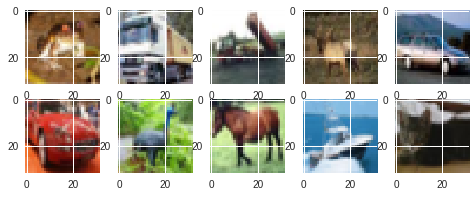

In [0]:
plt.figure(figsize=(8,3))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(X_train.reshape(-1, 32, 32, 3)[i])

### Preparing the data

Reshaping the training and testing features into 4D tensor with a shape of (32, 32, 3). These images are colored so they have 3 channels - red, green, blue.

In [0]:
X_train = X_train.reshape((50000,32,32,3))
X_test = X_test.reshape((10000,32,32,3))

X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

print(X_train.shape, X_test.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)


In [0]:
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

print(y_train.shape, y_test.shape)

(50000, 10) (10000, 10)


Our data is now ready for modeling. Because these images are a bit more complex than handwritten digits, were going to add more complexity to this model. Im going to start off with a deep CNN  with 3 stacked convolution layers followed by max pooling. I will also include Dropout layers to reduce overfitting. I'll also increase the number of neurons (or filters) as the layers progress. Lets see how this model performs. 

### Build the model

In [0]:
K.clear_session()

model = Sequential()
model.add(Conv2D(48, (3,3), padding='same', input_shape=(32, 32, 3), activation='relu'))
model.add(Conv2D(48, (3,3), activation='relu'))
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(96, (3,3), padding='same', activation='relu'))
model.add(Conv2D(96, (3,3), activation='relu'))
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(192, (3,3), padding='same', activation='relu'))
model.add(Conv2D(192, (3,3), activation='relu'))
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.25))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 48)        1344      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 48)        20784     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 48)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 48)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 96)        41568     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 96)        83040     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 96)          0         
__________

The architecture is as follows:

- 3 layers of double stacked Conv2D layers, followed by a MaxPool2D layer and a Dropout layer set at 0.25.
- The model has 644,784 parameters. 

So, the logic behind this model is to increase the complexity, while at the same time trying to reduce overfitting. We'll now add these layers to a densely connected classifer. For this part I'll increase the Dropout layer to 0.5 to further reduce overfitting.

In [0]:
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 48)        1344      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 48)        20784     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 48)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 48)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 96)        41568     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 96)        83040     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 96)          0         
__________

The output of first part of the network is (2, 2, 192). We'll now use this as input for a Flatten layer, which turns the 3D (or 4D if youre couting the batch dimension) tensor into a vector of shape (768,).  Those 768 inputs will then produce 512 outputs using another 'relu' activation function. That output is then put into another dense layer with 256 neurons. The final Dense layer has 10 neurons and contains the 'softmax' function. 

I'll now compile and train the model like we did before.

### Compile and Train the Model

I'll use categorical_crossentropy as the loss function, but instead of 'rmsprop' were going to use 'adam' to optimize the loss function. Im also going to increase the number of training epochs to 100 and the batch size to 128. To see how well it generalizes during training, the validation split will be 10%.

In [0]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=100, batch_size=128, validation_split=0.1)

Train on 45000 samples, validate on 5000 samples
Epoch 1/100
45000/45000 [==============================] - 20s 434us/step - loss: 1.8904 - acc: 0.2794 - val_loss: 1.5003 - val_acc: 0.4502
Epoch 2/100
45000/45000 [==============================] - 18s 400us/step - loss: 1.3803 - acc: 0.4961 - val_loss: 1.1114 - val_acc: 0.5964
Epoch 3/100
45000/45000 [==============================] - 18s 398us/step - loss: 1.1567 - acc: 0.5869 - val_loss: 0.9656 - val_acc: 0.6540
Epoch 4/100
45000/45000 [==============================] - 18s 400us/step - loss: 1.0265 - acc: 0.6382 - val_loss: 0.8710 - val_acc: 0.6916
Epoch 5/100
45000/45000 [==============================] - 18s 404us/step - loss: 0.9277 - acc: 0.6759 - val_loss: 0.7747 - val_acc: 0.7256
Epoch 6/100
45000/45000 [==============================] - 18s 401us/step - loss: 0.8421 - acc: 0.7061 - val_loss: 0.7520 - val_acc: 0.7402
Epoch 7/100
45000/45000 [==============================] - 18s 399us/step - loss: 0.7851 - acc: 0.7308 - val_lo

Lets visualize the results using the history object and turning it into a dictionary.

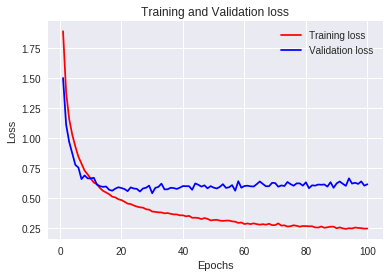

In [0]:
history_dict2 = history.history
loss = history_dict2['loss']
val_loss = history_dict2['val_loss']
acc = history_dict2['acc']
val_acc = history_dict2['val_acc']

epochs = range(1,101)
plt.plot(epochs, loss, c='r', label='Training loss')
plt.plot(epochs, val_loss, c='b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

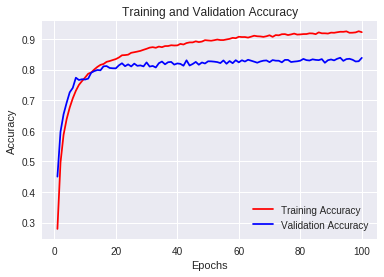

In [0]:
plt.plot(epochs, acc, c='r', label='Training Accuracy')
plt.plot(epochs, val_acc, c='b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Looks like our model did pretty well, 83.18% accuracy, which is good enough for an initial image recognition system. But we can also see that it begins overfitting before 20 epochs. If the stakeholders would like to achieve greater accuracy, we can improve the model by doing the following:

- Change the architecture and iteratively fine tune the model.
- Further regularize with either kernel regularizers or batch normalization.
- Conduct data augmentation or use a pretrained convnet.


Were going to try adding data augmentation. This works by generating more training data from existing training examples. This will ensure that the model doesnt see the exact same picture twice, allowing it to learn from more examples and therefore, generalize better on unseen data. 


### Data Augmentation

I'll set up a data augmentation configuration using ImageDataGenerator, which transforms the data using a number of methods. Were going to horizontally flip the data and zoom in 20%.

This time instead of saving some of the training data for validation, we'll use the testing data to evaluate our model. W We'll train for 100 epochs at a batch size of 128. When it comes to choosing the right amount of steps per epoch, practioners typically use train_length // batch_size. Using this (50000//128) we arrive at 390 steps per epoch. Lets now train and then visualize our results.

In [25]:
from keras.preprocessing.image import ImageDataGenerator

K.clear_session()

model = Sequential()
model.add(Conv2D(48, (3,3), padding='same', input_shape=(32, 32, 3), activation='relu'))
model.add(Conv2D(48, (3,3), activation='relu'))
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(96, (3,3), padding='same', activation='relu'))
model.add(Conv2D(96, (3,3), activation='relu'))
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(192, (3,3), padding='same', activation='relu'))
model.add(Conv2D(192, (3,3), activation='relu'))
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

gen = ImageDataGenerator(zoom_range=0.2,
                         horizontal_flip=True)


history = model.fit_generator(gen.flow(X_train, y_train, batch_size=128),
                             steps_per_epoch=390,
                             epochs=100,
                             validation_data=(X_test, y_test))


Epoch 1/100
390/390 [==============================] - 32s 82ms/step - loss: 1.9056 - acc: 0.2732 - val_loss: 1.5032 - val_acc: 0.4378
Epoch 2/100
390/390 [==============================] - 31s 80ms/step - loss: 1.4941 - acc: 0.4559 - val_loss: 1.2146 - val_acc: 0.5535
Epoch 3/100
390/390 [==============================] - 30s 78ms/step - loss: 1.2961 - acc: 0.5377 - val_loss: 1.1195 - val_acc: 0.5975
Epoch 4/100
390/390 [==============================] - 31s 80ms/step - loss: 1.1684 - acc: 0.5899 - val_loss: 0.9826 - val_acc: 0.6501
Epoch 5/100
390/390 [==============================] - 31s 79ms/step - loss: 1.0697 - acc: 0.6273 - val_loss: 0.9159 - val_acc: 0.6813
Epoch 6/100
390/390 [==============================] - 30s 78ms/step - loss: 0.9969 - acc: 0.6569 - val_loss: 0.8730 - val_acc: 0.7009
Epoch 7/100
390/390 [==============================] - 31s 80ms/step - loss: 0.9433 - acc: 0.6769 - val_loss: 0.8522 - val_acc: 0.7026
Epoch 8/100
390/390 [==============================] - 

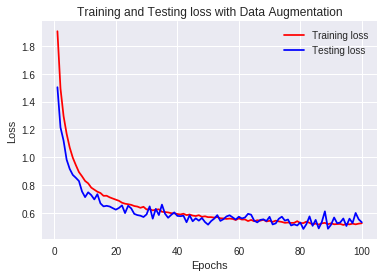

In [26]:
history_dict3 = history.history
loss = history_dict3['loss']
val_loss = history_dict3['val_loss']
acc = history_dict3['acc']
val_acc = history_dict3['val_acc']

epochs = range(1,101)
plt.plot(epochs, loss, c='r', label='Training loss')
plt.plot(epochs, val_loss, c='b', label='Testing loss')
plt.title('Training and Testing loss with Data Augmentation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

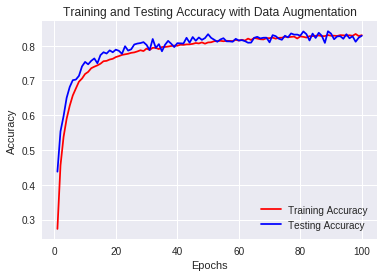

In [27]:
plt.plot(epochs, acc, c='r', label='Training Accuracy')
plt.plot(epochs, val_acc, c='b', label='Testing Accuracy')
plt.title('Training and Testing Accuracy with Data Augmentation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Using data augmentation we were to reduce the gap between the training and the testing scores. The accuracy got up to around 83% on the testing data, which is good, but not a huge improvement from our model without data augmentation. Best thing the data augmentation did was reduce the overfitting, which means this model generalizes well on unseen data. If we were to deploy this model into production it would be good start, but it would require further work. 

# 6. Summarize

After training several models on both MNIST and CIFAR10, we now have a model that can predict with decent accuracy, digits and random objects found on postcards. 

While the accuracy for the CIFAR10 dataset was lower then MNIST (which was expected), we still have a decent model that we can further fine tune before we put it into production. 



# Conclusion

Refering back to our original objective - to build an image recognition system capable of accurately classifying digits and images common to postcards - we were able to successfully accomplish both tasks. Here are some potential next steps:

- Further fine tune the model by tuning the hyperparameters (number of neurons, layers, etc.)
- More regularization.
- Use a pretrained convnet to further increase accuracy.
- Consider using recall, precision, or metrics to further evaluate the model. 

At this point in the workflow we would refine our process, thinking of ways to scale it and make it more robust,  and then finally present it to our business stakeholders. 













Thank you! If you have any questions, please feel free to contact me at aponted511@gmail.com